In [1]:
import librosa
import numpy as np
import torch

In [2]:
data, _ = librosa.load("data/LJ001-0001.wav")
data.shape

(212893,)

In [11]:
y = torch.from_numpy(data)
spec = torch.stft(y, n_fft=2048, hop_length=256, window=torch.hann_window(1024), win_length=1024, center=False, pad_mode="reflect")
print(spec.shape)

torch.Size([1025, 824, 2])


In [12]:
spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))
print(spec.shape)

torch.Size([1025, 824])


In [15]:
mel = librosa.filters.mel(sr=22050, n_fft=2048, n_mels=80, fmin=0, fmax=8000)
print(mel.shape)
spec = torch.matmul(torch.Tensor(mel), spec)

print(spec.shape)

(80, 1025)
torch.Size([80, 824])


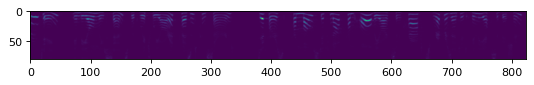

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.imshow(spec)
plt.show()

In [17]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

In [18]:
spec = spectral_normalize_torch(spec)

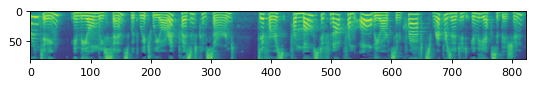

In [19]:
figure(figsize=(8, 6), dpi=80)
plt.imshow(spec)
plt.show()

In [21]:
np.save("opt.npy", spec.numpy())

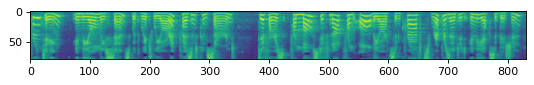

In [23]:
spec2 = np.load("data/LJ001-0001_mel.npy")
spec2 = np.squeeze(spec2)
figure(figsize=(8, 6), dpi=80)
plt.imshow(spec2)
plt.show()

In [25]:
spec1 = spec.numpy()
print(np.max(spec1))
print(np.max(spec2))

2.1409192
1.4685507


In [29]:
from librosa.filters import mel as librosa_mel_fn

mel_basis = {}
hann_window = {}


def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [40]:
y = torch.from_numpy(data)
y = y.unsqueeze(0)

spec3 = mel_spectrogram(y, n_fft=2048, num_mels=80, sampling_rate=22050, hop_size=256, win_size=1024, fmin=0, fmax=8000)

In [41]:
torch.max(spec3)

tensor(2.1574)

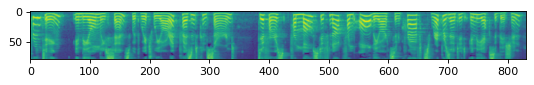

In [43]:
figure(figsize=(8, 6), dpi=80)

plt.imshow(spec3.squeeze())
plt.show()

In [44]:
np.save("opt.npy", spec3.numpy())